## 감정분석 + BERT
버트로 모델링하기

### BERT - airline review sentiment analysis
- 목표: 만든 파일로 모델을 만들어서 모델이 리뷰를 positive, negative로 잘 분류할 수 있게 한다.
1. train, test set으로 나눔
2. train set으로 모델을 만들고
3. test set에서 정확도를 계산한다.

In [21]:
import os, re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# random seed 고정
tf.random.set_seed(1234)
np.random.seed(123)

# parameters
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 16 * 2

OUT_PATH = '../data_out/'
IN_PATH = '../data'

#### load data

In [39]:
file = os.path.join(IN_PATH, 'OUT', 'tweets_public_polarity.csv')

df = pd.read_csv(file, sep='\t', encoding='utf-8')
df.head(3)

,Unnamed: 0,text,airline_sentiment,at,polarity,label
0,0,Trabajar en Ryanair como TMA: empleo,neutral,NaN,0.230391,0.0
1,1,Cuando gusten en Cancún se viaja y disfruta ...,neutral,@Iberia,0.025044,0.0
2,2,Sabiais que te trata muy bien en santiago de ...,negative,NaN,0.350941,2.0


In [40]:
del df['Unnamed: 0']
df = df.dropna() # 없는 값 삭제하기

#### max_len

In [41]:
# MAX_LEN는 average * 2
import nltk
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

# test
tokenizer.tokenize('hello, world.')

['hello', ',', 'world', '.']

In [42]:
df['tokens'] = df.text.apply(lambda x: len(tokenizer.tokenize(str(x))))
df.head(1)

,text,airline_sentiment,at,polarity,label,tokens
1,Cuando gusten en Cancún se viaja y disfruta ...,neutral,@Iberia,0.025044,0.0,12


In [43]:
df.tokens.describe()

count    3695.000000
mean       15.928552
std         7.425084
min         0.000000
25%        10.000000
50%        18.000000
75%        22.000000
max        34.000000
Name: tokens, dtype: float64

### train, test set 분리

In [44]:
X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123)

In [45]:
len(X_train), len(X_test)

(2956, 739)

#### df label 개수

In [46]:
X_train.label.value_counts()

2.0    1627
0.0     885
1.0     444
Name: label, dtype: int64

In [47]:
X_train.sample(4)

,text,airline_sentiment,at,polarity,label,tokens
2436,Pues si y no. Pq me dijeron que probablemente...,negative,@Iberia,1.610742e-10,2.0,23
489,L…,negative,@planeaconlena,4.978923e-01,2.0,2
2622,Bueno Ryanair es low cost...,negative,@QuiqueBoeing,5.804897e-01,2.0,6
7408,Habeis escrito algo después de lo q yo os he ...,negative,@Iberia,8.509542e-06,2.0,23


### BERT tokenizer

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          cache_dir='bert_ckpt',
                                          do_lower_case=False)

In [49]:
sent = 'hola, encantada!'
encode = tokenizer.encode(sent)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 110516, 10113, 117, 10110, 62745, 11153, 106, 102]
['[ C L S ]', 'h o l', '# # a', ',', 'e n', '# # c a n t', '# # a d a', '!', '[ S E P ]']


In [50]:
# 버트에 있는 토큰 종류들
print(tokenizer.all_special_tokens, '\n', tokenizer.all_special_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]


In [51]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text=sent,
        add_special_tokens=True,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        return_attention_mask=True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(X_train.text, X_train.label), total=len(X_train)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass

  0%|          | 0/2956 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 2956/2956 [00:00<00:00, 3145.05it/s]


In [52]:
train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

In [53]:
print('# sent: {}, # labels: {}'.format(len(train_input_ids), len(train_data_labels)))

# sent: 2956, # labels: 2956


In [54]:
input_id = train_input_ids[1]
attention_mask = train_attention_masks[1]
token_type_id = train_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101  10657  12796 107788  16466  20039  11559  18345  10121 100154
  55174    102      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] No worries Ryanair está mejor que Vueling [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


### 분류

In [55]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                               kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                               name='classifier')
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        
        return logits
    
cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                            dir_path='bert_ckpt',
                            num_class=2)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### optimize

In [56]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer,
                 loss=loss,
                 metrics=[metric])

In [58]:
model_name = 'tf2_bert_es_airline_sentiment'

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = os.path.join(OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    "{} -- Folder create complete \n".format(checkpoint_dir)

In [59]:
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True
)

In [60]:
history = cls_model.fit(train_inputs, train_data_labels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                       validation_split=VALID_SPLIT,
                       callbacks=[earlystop_callback, cp_callback])

print(history.history)

Epoch 1/3
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
74/74 [==============================] - 19s 82ms/step - loss: nan - accuracy: 0.2936 - val_loss: nan - val_accuracy: 0.3209

Epoch 00001: val_accuracy improved from -inf to 0.32095, saving model to ../data_out/tf2_bert_es_airline_sentiment/weights.h5
Epoch 2/3
74/74 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.2940 - val_loss: nan - val_accuracy: 0.3209

Epoch 00002: val_accuracy did not improve from 0.32095
Epoch 3/3
74/74 [==============================] - 4s 57ms/step - loss: nan - accuracy: 0.2940 - val_loss: nan - val_accuracy: 0.3209

Epoch 00003: val_accuracy did not improve from 0.32095
{'loss': [nan, nan, nan], 'accuracy': [0.29357022047042847, 0.2939932346343994, 0.2939932346343994], 'val_loss': [nan, nan, nan], 'val_accuracy': [0.32094594836235046, 0.32094594836235046, 0.32094594836235046]}


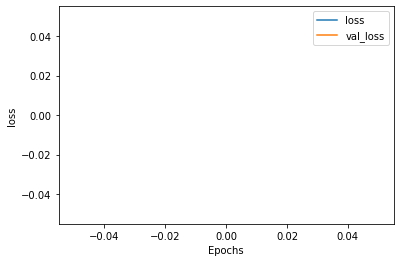

In [61]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'loss')

### Test

In [62]:
X_test.sample(1)

,text,airline_sentiment,at,polarity,label,tokens
3547,sí ya he volado pero no tengo la tarjeta de ...,neutral,@Iberia,0.000048,0.0,11


In [63]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(X_test.text, X_test.label)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass
    
test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.asarray(test_data_labels, dtype=np.int32)

print("num sents, labels {}, {}".format(len(test_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
739it [00:00, 3389.35it/s]

num sents, labels 739, 739


In [64]:
results = cls_model.evaluate(test_inputs, test_data_labels, batch_size=1024)
print('test loss, test acc: ', results)

1/1 [==============================] - 0s 200ms/step - loss: nan - accuracy: 0.3180
test loss, test acc:  [nan, 0.3179973065853119]


In [68]:
X_test.loc[:, ['text', 'label']].sample(5)

,text,label
7110,Este avion tiene 12 años de antiguedad y entr...,0.0
506,"Envié un privado x una reserva, podrán soluc...",2.0
6869,Si Ryanair cobra por esto y al final el total...,0.0
4407,Por suerte viaja mi amigo...yo estoy disf...,1.0
6384,Es una pena que sea una práctica comercial l...,2.0


In [ ]:
label_dict = {'negative': 2, 'positive': 1, 'neutral': 0}

def find_label(num_label):
    return next(key for key, value in label_dict.items() if value == num_label) # 반복할 수 있을 때는 해당 값을 출력하고, 반복이 끝났을 때는 기본값을 출력